# Creating A DMF Solvent Box for OpenMM using OPLS-AA
http://dx.doi.org/10.1021/ct200731v  

Meant to be used for QM/MM MD Simulations. The plan is to:

1. Create the solvent box from a single DMF where we already have a gromacs .top and .itp that has the correct atom types. The top was from http://virtualchemistry.org which is unfortunately often down. It contains all the structures from the database in the doi above. 
2. Equilibrate the box in NPT
3. Cut out room for the solute  
    A. Manually edit the topology and positions to remove overlapping molecules
4. Use an ASE-OpenMM interface for the QM/MM, so it is the (slow) ASE taking care of dynamics and constraints, and OpenMM just delivers forces and energies as any other ASE calculator

This notebook uses an `openmoltools` packaging of the `packmol` code. You should be able to install it with `conda install -c conda-forge -c omnia openmoltools`


NB: This has been made with the newest openmm, where `simtk` has been removed. Prepend it again to all openmm imports if you haven't updated yet (or update OpenMM..)


In [4]:
%reset -f
%load_ext autoreload
%autoreload 2

%config Completer.use_jedi = False


import os
import sys
import matplotlib 

%matplotlib notebook
import matplotlib.pyplot as plt
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{cmbright}')
matplotlib.rc('axes.formatter', limits= (-2, 2))
plt.rcParams.update({'font.size': 14})


import numpy as np
import openmoltools  # -- needs to update to remove simtk from updates.
import mdtraj
import nglview
from copy import deepcopy
from openmm.vec3 import Vec3
from openmm import unit as u
from openmm.app import GromacsGroFile, GromacsTopFile
from openmm import app
import parmed as pmd 
from sys import stdout
from openmm.openmm import MonteCarloBarostat, LangevinIntegrator

import foyer
import mbuild as mb


from cmm.md.cmmsystems import CMMSystem
from simtk.openmm.app import GromacsGroFile
import MDAnalysis as mda
from MDAnalysis.analysis.rdf import InterRDF



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the pdb as an mdtraj: 

In [5]:
traj = mdtraj.load_pdb('../../data/md/dmf/dmf.pdb')
v = nglview.show_mdtraj(traj)
v

NGLWidget()

Make a 512 mol box:

In [6]:
num_mols = 512
box = openmoltools.packmol.pack_box(traj[-1], [num_mols])


# Mixture

tolerance 2.000000
filetype pdb
output /tmp/tmp1p2f_pmc/tmp1tfllfau.pdb
add_amber_ter


structure /tmp/tmp1p2f_pmc/tmpnl4bxn56.pdb
  number 512
  inside box 0. 0. 0. 74.662718 74.662718 74.662718
end structure


################################################################################

 PACKMOL - Packing optimization for the automated generation of
 starting configurations for molecular dynamics simulations.
 
                                                              Version 18.013 

################################################################################

  Packmol must be run with: packmol < inputfile.inp 

  Userguide at: www.ime.unicamp.br/~martinez/packmol 

  Reading input file... (Control-C aborts)
  Will add the TER flag between molecules. 
  Seed for random number generator:      1234567
  Output file: /tmp/tmp1p2f_pmc/tmp1tfllfau.pdb
  Reading coordinate file: /tmp/tmp1p2f_pmc/tmpnl4bxn56.pdb
  Number of independent structures:            1
  Th

Use Foyer to type the box (takes a bit):

In [7]:
oplsaa = foyer.forcefields.load_OPLSAA()  # load OPLS
compound = mb.load(box)
out = oplsaa.apply(compound)

/opt/tljh/user/envs/py38/lib/python3.8/site-packages/foyer/forcefield.py:348: UserWarning: Parameters have not been assigned to all impropers. Total system impropers: 5120, Parameterized impropers: 0. Note that if your system contains torsions of Ryckaert-Bellemans functional form, all of these torsions are processed as propers
  warnings.warn(msg)


Use Parmed to save prmtop (and Gromacs top/gro. Loading these did not give the right structure though)

In [10]:
out.save('dmfbox.top', overwrite=True)
out.save('dmfbox.gro', overwrite=True)
out.save('dmfbox.prmtop', overwrite=True)

Run NPT

In [ ]:
# init
sys = CMMSystem('dmfbox_npt', fpath='./')

# prmtop
sys.system_from_prmtop('dmfbox.prmtop')

# update pos
gro = GromacsGroFile('dmfbox.gro')
pos = gro.getPositions(asNumpy=True)
sys.update_positions(pos.in_units_of(u.angstrom)._value)

# NP
sys.add_barostat()

# T
sys.set_integrator()

# init sim
sys.init_simulation()

# minimize
sys.minimize()

# reporters
sys.standard_reporters()

# runnnn
sys.run(time_in_ps=200)


Check equilibration

<IPython.core.display.Javascript object>


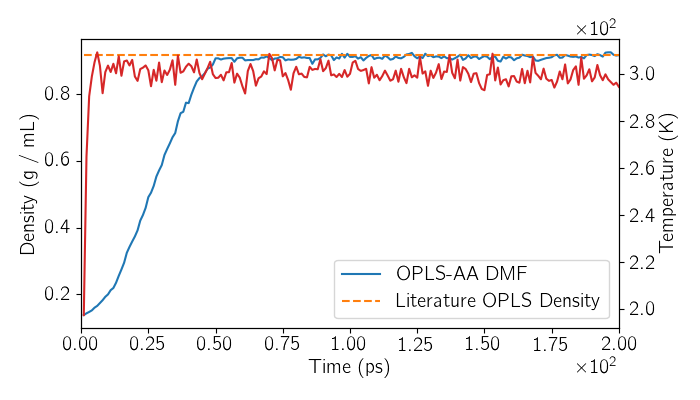

In [19]:
log = np.genfromtxt('dmfbox_npt.log', skip_header=1)


dt = 2e-3
fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.plot(log[:, 0] * dt, log[:, -2], label='OPLS-AA DMF')
ax.plot(log[:, 0] * dt, 0 * log[:, 0] + 0.918, '--' ,label='Literature OPLS Density')
ax.legend(loc='best')

ax2 = ax.twinx()
ax2.plot(log[:, 0] * dt, log[:, 2], 'C3')
ax.set_ylabel('Density (g / mL)')
ax2.set_ylabel('Temperature (K)')

for ax in (ax, ax2):
    ax.set_xlabel('Time (ps)')
    ax.set_xlim([0, 200])

fig.tight_layout()

Compare RDFs. 

Selecting by indicices, since the MDAnalysis universe names all prmtop-read atoms in simply as "opls". The top is no better. It does save the charges though. The paper has the charge values (or go to http://dx.doi.org/10.1016/j.molliq.2015.03.004 to find them)

In [36]:
u_opls = mda.Universe('./dmfbox.prmtop', './dmfbox_npt.dcd')

cdict = {'CA': '0.5', 'CM': '-0.11', 'HA': '0.0', 'HM': '0.06', 'OA':'-0.5', 'N':'-0.14'}
cdict = dict((v,k) for k,v in cdict.items())
order = [cdict[str(round(x, 2))] for x in u_opls.atoms.charges[:12]]

mol1 = u_opls.select_atoms('bynum 1:12')
v = nglview.show_mdanalysis(mol1)
for a, atom in enumerate(mol1):
    v.shape.add('text', atom.position.tolist(), [0, 0.0, 0], 1.0, f'{a}: ' + order[a])
v

NGLWidget(max_frame=199)

In [50]:
start_frame = 50

# set r_max to minimum of the cells in the sampled part of the NPT run
r_max = np.min(np.concatenate([frame.dimensions[:3] for frame in u_opls.trajectory[start_frame:]])) / 2

dr = 0.05
r_range = (0.0, r_max)
nbins = len(np.arange(r_range[0], r_range[1], dr))


# Os are easy
OA = u_opls.select_atoms('name O')

# HA is idx 10 (see above) but bynum is 1-indexed
idx = list(range(11, 512 * 12, 12))
selstr = 'bynum ' +  ' or bynum '.join(str(i) for i in idx)
HA = u_opls.select_atoms(selstr)

# CA ditto (see above):
idx = list(range(10, 512 * 12, 12))
selstr = 'bynum ' +  ' or bynum '.join(str(i) for i in idx)
CA = u_opls.select_atoms(selstr)
rdf_opls = InterRDF(OA, CA, nbins=nbins, range=r_range)
rdf_opls.run(start=start_frame, stop=-1)


<IPython.core.display.Javascript object>


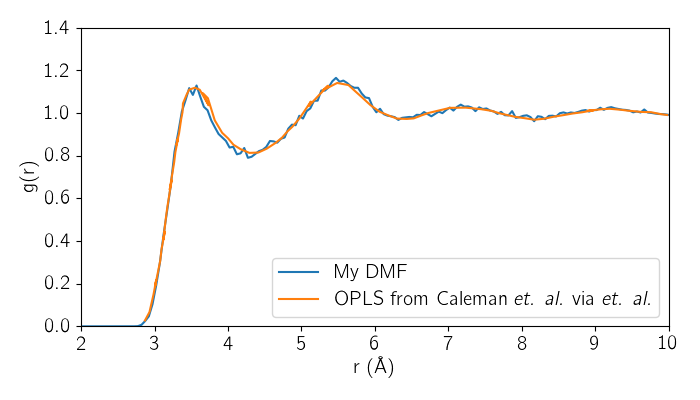

In [51]:
cale = np.genfromtxt('/home/asod/Dropbox/HI/Benni/DMF/dmf_OA-CA-caleman.csv', delimiter=',')

fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.plot(rdf_opls.results.bins, rdf_opls.results.rdf, label='My DMF')
ax.plot(cale[:, 0], cale[:, 1], label='OPLS from Caleman \\emph{et. al.} via \\emph{et. al.}')

ax.set_ylim([0, 1.4])
ax.set_xlim([2, 10])
ax.set_ylabel('g(r)')
ax.set_xlabel('r (Å)')
ax.legend(loc='lower right')
fig.tight_layout()


It is _pretty_ close. Things that could be different: 

1. Different thermostats
2. Different MD programs (i.e. possible different cutoffs and integrators)
3. I am not 100% sure OpenMM uses the OPLS comining rules (both sigma and eps are np.sqrt(AB) - no (A + B) / 2). I would assume this gives larger discrepancies, however.


W.r.t. 3: OpenMM automatically detects OPLS, sets the LJ parameters in `NonbondedForce` to 0, and adds a `CustomNonbondedForce` object with the OPLS LJ form. This means the CMMSystem `adjust_lj` **will not work**. It is not possible to change the LJ parameters in `CustomNonbondedForce` the same way as in `NonbondedForce`.


http://docs.openmm.org/latest/userguide/theory/02_standard_forces.html#lennard-jones-interaction

## Solvate:
1. Load things
2. Cut out overlapping molecules
3. Fix topology

Then update the ASE OpenMMcalc to work with QMMM